In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import emoji
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel, CoherenceModel
from gensim import models
from wordcloud import WordCloud
import pandas as pd
from collections import defaultdict, Counter


In [2]:
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)

print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


In [3]:
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /Users/blackrose/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/blackrose/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blackrose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "]+", flags=re.UNICODE)

def contains_emoji(text):
    return emoji_pattern.search(text) is not None

# check which texts contain emojis
texts_with_emojis = [text for text in train_texts if contains_emoji(text)]

print(texts_with_emojis[:5])
print(len(texts_with_emojis))

['Why have I only just started watching glee this week I am now addicted 🙄 #glee #GLEEK', "@user bts' 화양연화 trilogy MV is my all time fav🙌 quite gloomy but beautiful as well✨", "Rewatching 'Raising Hope' (with hubs this time) and totally forgot how hilarious it is 😂 #HereWeGo", "On the bright side, my music theory teacher just pocket dabbed and said, 'I know what's hip.' And walked away 😂😭", "i was so embarrassed when she saw us i was like knvfkkjg she thinks we're stalkers n then she starts waving all cheerfully inviting us in 😩"]
276


In [5]:
# preprocessing 
contractions_map = {
    "can't": "cannot",
    "don't": "do not",
    "does't": "does not",
    "dont": "do not",
    "doesnt": "does not",
    "cant": "cannot",
    "won't": "will not",
    "shan't": "shall not",
    "wont": "will not",
    "shant": "shall not",
    "shouldn't": "should not",
    "shouldnt": "should not",
    # "n't": " not",
    "'ll": " will",
    "'ve": " have",
    "'re": " are",
    "'d": " would",
    "'s": " is",
    "I'm": "i am",
    "Im": "i am",
    "i'm": "i am",
    "im": "i am"
}


def normalize_repeated_letters(text):
    return re.sub(r'(.)\1{4,}', r'\1\1', text)


def contractions(text):
    for contraction, expanded_form in contractions_map.items():
        text = text.replace(contraction, expanded_form)
    words = nltk.word_tokenize(text)
    new_words = []
    negation = False

    for i, word in enumerate(words):
        if word.lower() in ["not", "no", "never", "nobody", "nothing", "neither", "nowhere", "cannot"] and i + 1 < len(words):
            # new_words.append("NOT_" + words[i + 1])
            negation = True
            continue
        if negation:
            negation = False
            continue
        new_words.append(word)

    return ' '.join(new_words)


    
def preprocessing_text(text):
    
    # convert all texts to lowercase
    text = text.lower()
  
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove URLs
    text = re.sub(r'https?://\S+|\.com$', '', text)
    
    # remove HTML link
    text = re.sub(r'\<br /\>', r' ', text)
    

    # remove any word which have @ symbols
    text = re.sub(r'@\w+', '', text)

    #### emoji block ####
    # replace emojis with text
    text = emoji.demojize(text, language='alias')

    # remove colons and replace underscores with spaces
    text = re.sub(r':([^:\s]*):', lambda m: m.group(1).replace('_', ' '), text)
    #### emoji block ####

    # remove symbols
    text = re.sub(r'[\.\!\?\$\%\#\;\:\-\&\@\+\=\_\"\'\,\)\(\*]*[\r\n]*', '', text)

    # remove repeating character like hungryyyyyyy
    text = normalize_repeated_letters(text)

    # contractions sequence
    text = contractions(text)

    # tokenize text
    words = nltk.word_tokenize(text)
    # print(words)
    # remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # print(words)
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # print(words)
    # # Stemming words
    # stemmer = nltk.PorterStemmer() 
    # words = [stemmer.stem(word) for word in words]

    # join words into string
    text = ' '.join(words)
    return text


# # preprocess
processed_train = [preprocessing_text(txt).split() for txt in train_texts]
processed_val = [preprocessing_text(txt).split() for txt in val_texts]
processed_test = [preprocessing_text(txt).split() for txt in test_texts]

In [6]:
processed_all = processed_train + processed_val + processed_test

In [7]:
dictionary = Dictionary(processed_train) # construct word<->id mappings
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_all]

Dictionary<7926 unique tokens: ['joyce', 'leadership', 'may', 'meyer', 'motivation']...>


## Latent Dirichlet Allocation (LDA)

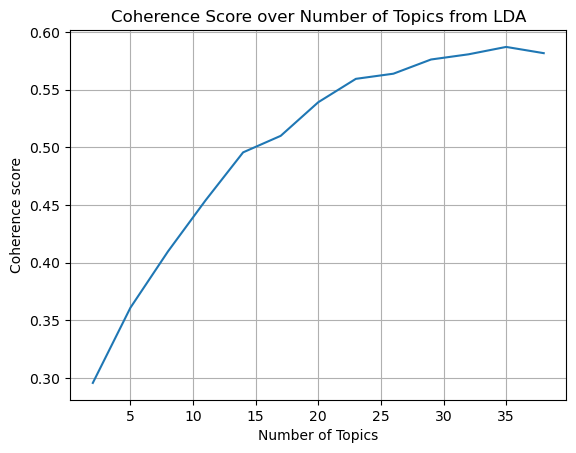

In [8]:
# coherence score over number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(2, limit, step):
        model_topic = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=10)
        model_list.append(model_topic)
        coherencemodel = CoherenceModel(model=model_topic, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_train, limit=40, step=3)

x = range(2, 40, 3)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Score over Number of Topics from LDA")
plt.grid(True)
plt.show()


## Select number of topics and run LdaModel

Topic 0:
ha laugh threat fan revenge type people dear infuriate idiot



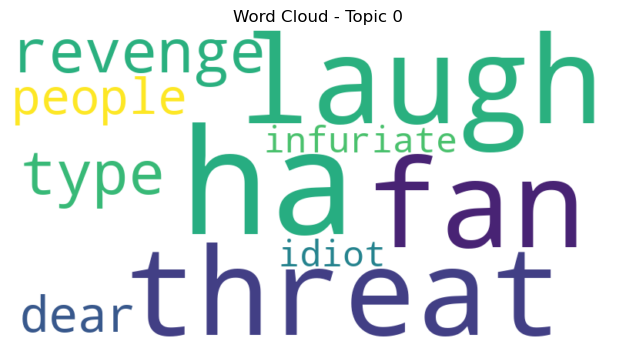

Topic 1:
giggle order he stupid damn shy instead cool train wonderful



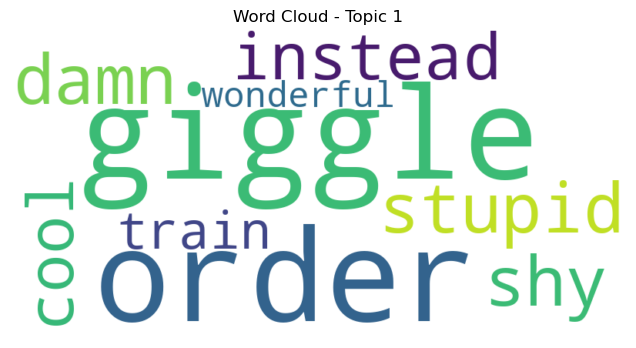

Topic 2:
thing start amp today one day year oh angry know



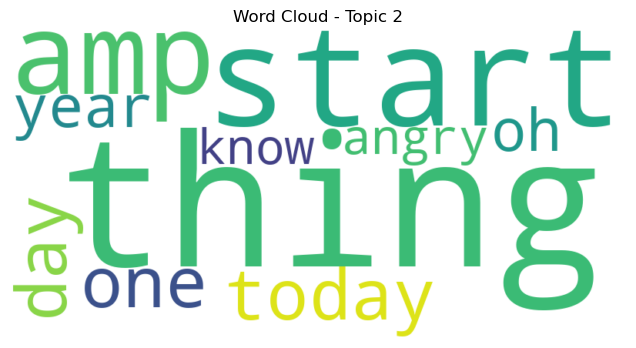

Topic 3:
fuming love people joy awful annoyed hi ti rabid stay



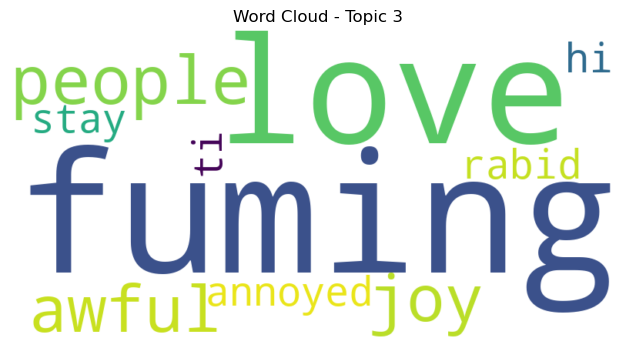

Topic 4:
face frowning nervous actually sob help excited sadly white next



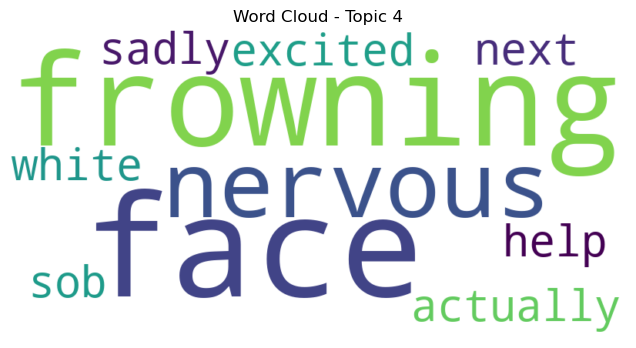

Topic 5:
money laughter amp adorable insult sad blush want hatred sadness



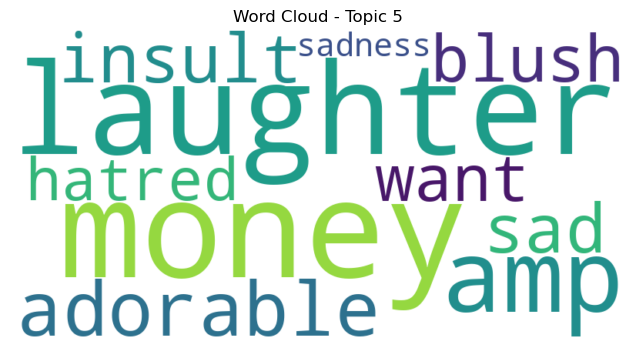

Topic 6:
cry sad depressed dream feeling gloomy alone like baby isnt



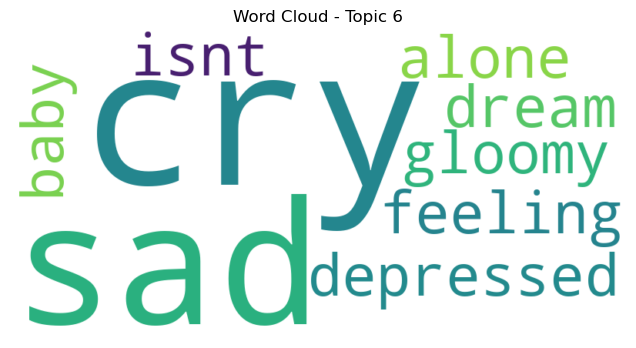

Topic 7:
amazing funny lively light skin let happy u musically birthday



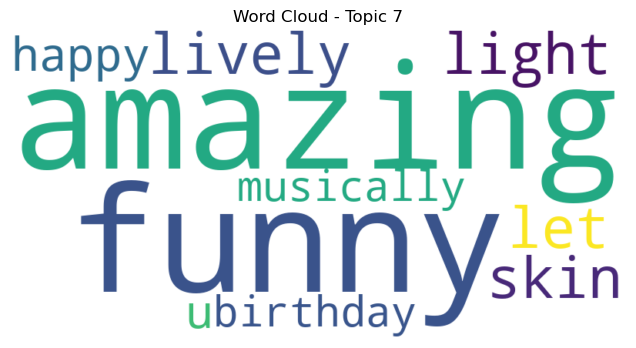

Topic 8:
furious please service concern tonight others depression knew customer get



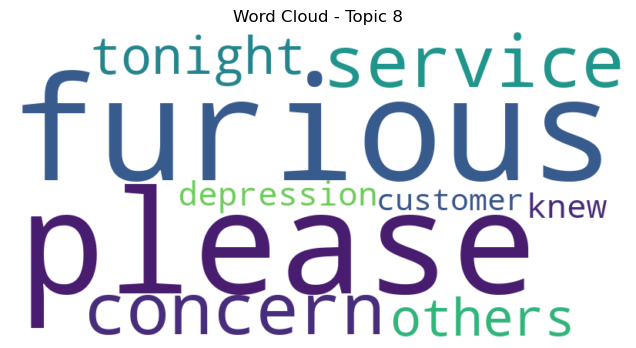

Topic 9:
smile crap u dread heart day love dull cry worried



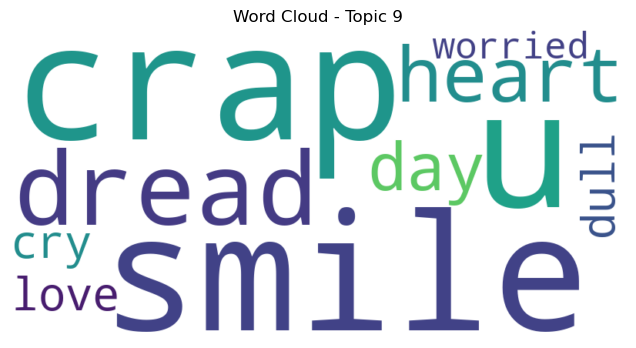

In [9]:
# TF-IDF model
tfidf_model = TfidfModel(bow_corpus)
corpus_tfidf = tfidf_model[bow_corpus]

# fit all texts to the LDA model
lda_model = models.LdaModel(corpus_tfidf, 
                             num_topics=10, 
                             id2word=dictionary,                                    
                             passes=10,
                             random_state=10,
                            )

num_topics = 10
num_top_words = 10

for topic_idx in range(num_topics):
    print("Topic %d:" % (topic_idx))
    top_words = lda_model.show_topic(topic_idx, topn=num_top_words)
    top_words = [word for word, _ in top_words]
    print(" ".join(top_words))
    print()

    # create word cloud for each topic
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_words))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Topic {}'.format(topic_idx))
    plt.show()


In [10]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
    

Topic: 0 
Words: 0.005*"ha" + 0.004*"laugh" + 0.004*"threat" + 0.004*"fan" + 0.003*"revenge" + 0.003*"type" + 0.003*"people" + 0.003*"dear" + 0.003*"infuriate" + 0.003*"idiot"


Topic: 1 
Words: 0.005*"giggle" + 0.005*"order" + 0.004*"he" + 0.004*"stupid" + 0.004*"damn" + 0.004*"shy" + 0.004*"instead" + 0.004*"cool" + 0.003*"train" + 0.003*"wonderful"


Topic: 2 
Words: 0.006*"thing" + 0.005*"start" + 0.005*"amp" + 0.004*"today" + 0.004*"one" + 0.004*"day" + 0.004*"year" + 0.004*"oh" + 0.004*"angry" + 0.004*"know"


Topic: 3 
Words: 0.007*"fuming" + 0.006*"love" + 0.005*"people" + 0.005*"joy" + 0.004*"awful" + 0.004*"annoyed" + 0.004*"hi" + 0.004*"ti" + 0.004*"rabid" + 0.004*"stay"


Topic: 4 
Words: 0.010*"face" + 0.008*"frowning" + 0.006*"nervous" + 0.006*"actually" + 0.005*"sob" + 0.005*"help" + 0.005*"excited" + 0.005*"sadly" + 0.005*"white" + 0.005*"next"


Topic: 5 
Words: 0.005*"money" + 0.004*"laughter" + 0.004*"amp" + 0.004*"adorable" + 0.004*"insult" + 0.004*"sad" + 0.004*"bl

## Identify emotion

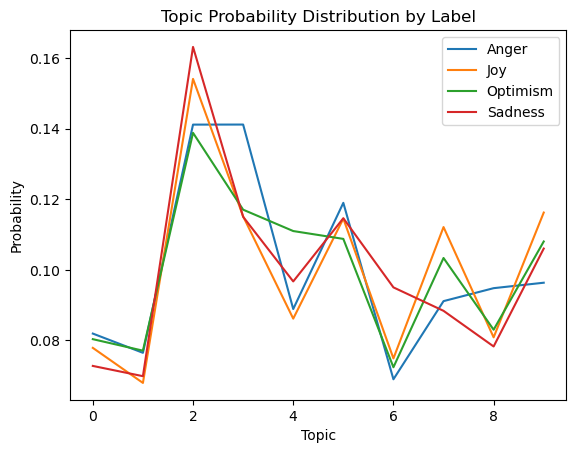

In [11]:
# identify topic probabilities of each document
lda_topic_probabilities = [lda_model[doc] for doc in corpus_tfidf]

# all label
document_labels = train_labels + val_labels + test_labels

# collect prob. of each label in each topic
label_topic_probabilities = {label: [0] * num_topics for label in set(document_labels)}

for doc_index, label in enumerate(document_labels):
    for topic_index, topic_probability in lda_topic_probabilities[doc_index]:
        label_topic_probabilities[label][topic_index] += topic_probability


for label in label_topic_probabilities:
    label_topic_probabilities[label] = [prob / document_labels.count(label) for prob in label_topic_probabilities[label]]

label_names = ['Anger', 'Joy', 'Optimism', 'Sadness']  
for label, probabilities in label_topic_probabilities.items():
    plt.plot(range(num_topics), probabilities, label=label_names[label])

plt.xlabel('Topic')
plt.ylabel('Probability')
plt.title('Topic Probability Distribution by Label')
plt.legend()
plt.show()


In [12]:
# show prob. of each emotional
topic_labels = ['Topic {}'.format(i) for i in range(num_topics)]
df_label_topic_prob = pd.DataFrame(label_topic_probabilities).T
df_label_topic_prob.columns = topic_labels
df_label_topic_prob.index = label_names


df_label_topic_prob

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Anger,0.081946,0.076492,0.141171,0.141188,0.088901,0.119001,0.068987,0.091140,0.094814,0.096359
Joy,0.077892,0.067958,0.154131,0.115174,0.086181,0.114515,0.074901,0.112132,0.080874,0.116242
Optimism,0.080361,0.077102,0.138839,0.117061,0.111004,0.108780,0.072401,0.103370,0.083037,0.108045
Sadness,0.072776,0.069871,0.163192,0.115041,0.096725,0.114639,0.095035,0.088391,0.078292,0.106037


In [13]:
label_word_counts = defaultdict(Counter)

for document, label in zip(processed_all, document_labels):
    words = document
    label_word_counts[label].update(words)

    

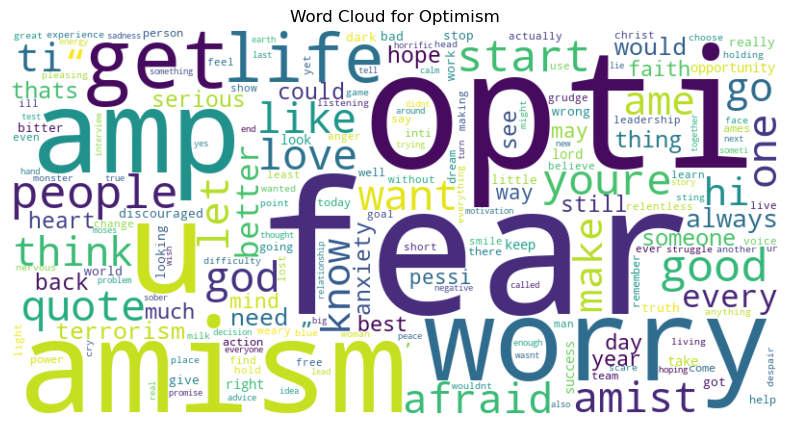

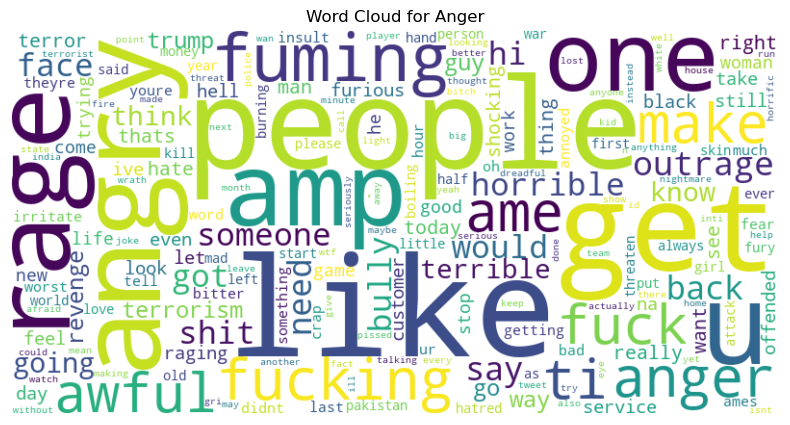

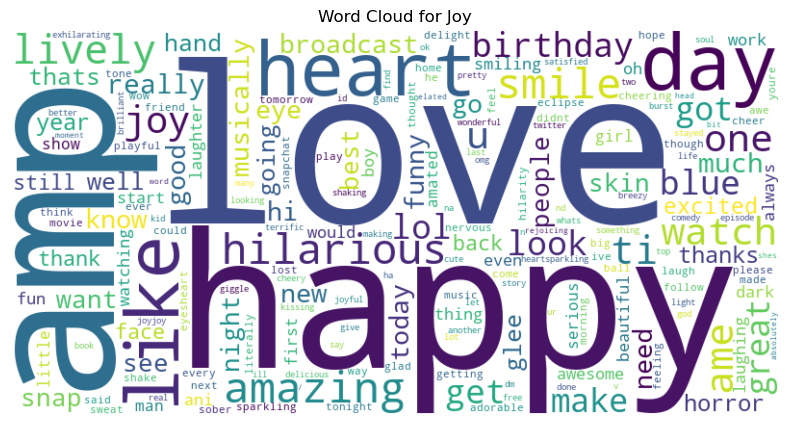

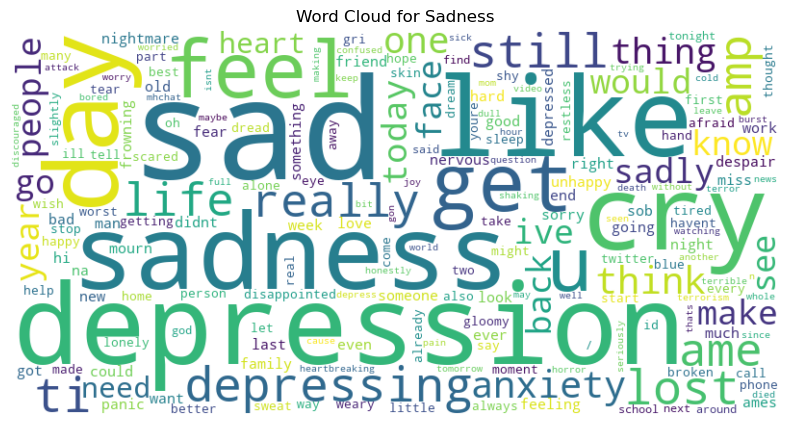

In [14]:
label_word_counts = defaultdict(Counter)

for document, label in zip(processed_all, document_labels):
    words = document
    label_word_counts[label].update(words)

# word clouds for each label
for label, counter in label_word_counts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {label_names[label]}') 
    plt.show()

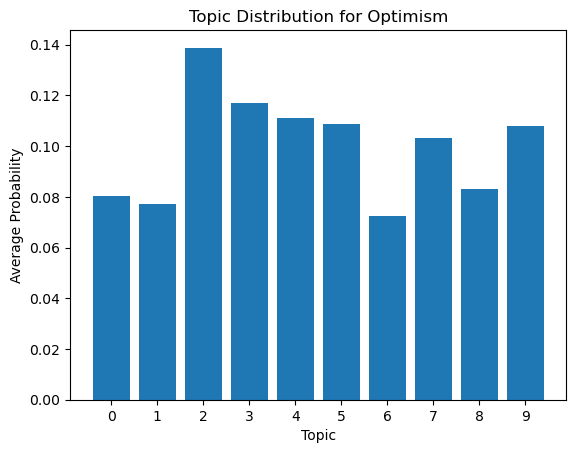

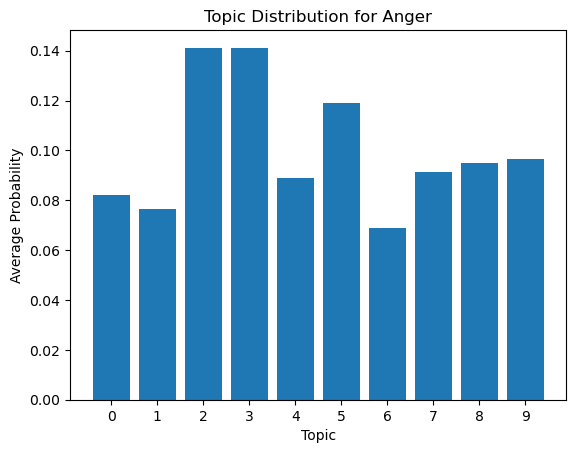

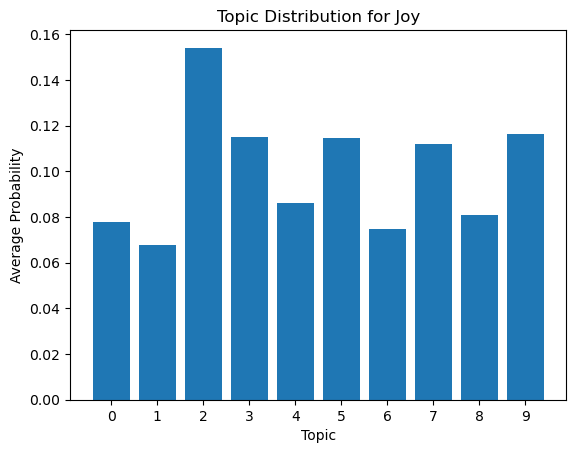

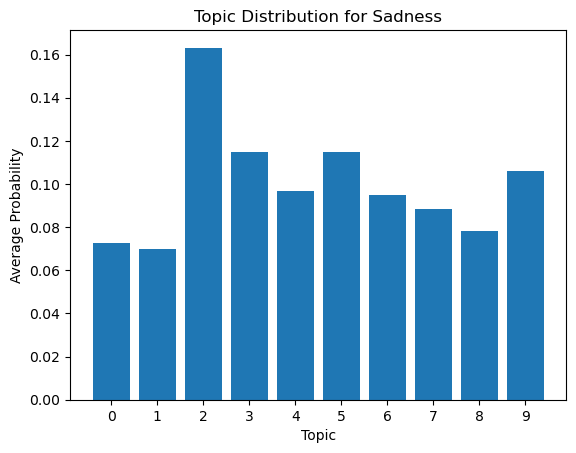

In [15]:
# sum prob. of topics for each label
topic_prob_sums = defaultdict(lambda: np.zeros(num_topics))

# sum prob. for each topic of all documents of each label
for probabilities, label in zip(lda_topic_probabilities, document_labels):
    for topic, probability in probabilities:
        topic_prob_sums[label][topic] += probability

# average prob.
num_docs_per_label = Counter(document_labels)
for label in topic_prob_sums:
    topic_prob_sums[label] /= num_docs_per_label[label]



for label, probabilities in topic_prob_sums.items():
    plt.figure()
    plt.bar(range(num_topics), probabilities, tick_label=range(num_topics))
    plt.xlabel('Topic')
    plt.ylabel('Average Probability')
    plt.title(f'Topic Distribution for {label_names[label]}')
    plt.show()
